### Ising model
Theory and implementation:
http://www.bdhammel.com/ising-model/

Implementation: only random initial state

### Cellular Potts model

Number of states: 3

In [111]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from numpy import genfromtxt
from IPython.display import clear_output
from numpy.random import RandomState
from tqdm import tqdm

In [2]:
%matplotlib inline

### План:
- функция рассчета объема клетки (продумать, как хранить или считать)
- дописать рассчет гамильтонинана
- настроить выбор нового положения 

In [630]:
class CellularPottsLattice:

    def __init__(self, temperature, system, size, interaction, lmbd, target_volume, types_num, cells_id, cells_size):
        self.size = size
        self.T = temperature
        self.system = system
        self.J = interaction
        self.lmbd = lmbd
        self.vt = target_volume
        self.types_num = types_num
        self.ids = cells_id
        self.cells_s = cells_size

    @property
    def sqr_size(self):
        return (self.size, self.size)

    
    def _build_system(self):
        """Build the system
        Build a randomly distributed system
        """

        system = np.random.choice([0, 1, 2], self.sqr_size)

        return system

    
    def _bc(self, i):
        """Apply periodic boundary condition
        Check if a lattice site coordinate falls out of bounds. If it does,
        apply periodic boundary condition
        Assumes lattice is square
        Parameters
        ----------
        i : int
            lattice site coordinate
        Return
        ------
        int
            corrected lattice site coordinate
        """
        if i >= self.size:
            return 0
        if i < 0:
            return self.size - 1
        else:
            return i
    
    
    def kronecker(self, spin_1, spin_2):
        '''Kronecker's delta. 
        1 if spin_1 == spin_2, 0 otherwise
        '''
        
        return float(spin_1 == spin_2)
    
    
    def volume(self, cell_id):
        n = 0
        for i in range(self.size):
            for j in range(self.size):
                if self.system[i, j] == cell_id:
                    n += 1
        return n
    
    
    def energy(self, N, M, E, ids):
        
        """Hamiltonian. Calculate the energy of spin interaction at a given lattice site
             
        Parameters
        ----------
        N : int
            lattice site coordinate
        M : int
            lattice site coordinate
        E : int
            spin
        Return
        ------
        float
            energy of the site
        """
        
        # neighbors types
#         print(N, M)
        type_1 = self.system[self._bc(N - 1), M]
#         print(f'E-{E+1}')
#         print(type_1)
        type_2 = self.system[self._bc(N + 1), M]
#         print(f'E-{E+1}')
#         print(type_2)
        type_3 = self.system[N, self._bc(M - 1)]
#         print(f'E-{E+1}')
#         print(type_3)
        type_4 = self.system[N, self._bc(M + 1)]
        
        energy_1 = self.J[E, type_1] * (1 - self.kronecker(E, self.system[self._bc(N - 1), M]))
        energy_2 = self.J[E, type_2] * (1 - self.kronecker(E, self.system[self._bc(N + 1), M]))
        energy_3 = self.J[E, type_3] * (1 - self.kronecker(E, self.system[N, self._bc(M - 1)]))
        energy_4 = self.J[E, type_4] * (1 - self.kronecker(E, self.system[N, self._bc(M + 1)]))
               
        # volume calculation  
        
        # для каждой клетки 
#         v_i = self.volume(ids)
        if self.vt[E] < 0:
            teta = 0
        else:
            teta = 1
        for i in range(196):
#             a = self.volume(ids)
            a = self.cells_s[i]
            A = self.vt[E]
            energy_volume = teta * self.lmbd * (a - A) ** 2
#         energy_volume = teta * self.lmbd * (self.cells_s[int(ids)] - self.vt[E]) ** 2
        
        
           
        energy = energy_1 + energy_2 + energy_3 + energy_4 + energy_volume
    
        return energy
    

In [738]:
def run(lattice, epochs):
    """Run the simulation
    """
          
#     cmap = matplotlib.cm.Blues
    
    for epoch in range(epochs):
        
        # Randomly select a site on the lattice
        N, M = np.random.randint(0, lattice.size, 2)
        # Current energy of spin
        en = lattice.system[N, M]
        cell_id = lattice.ids[N, M]
        # Calculate energy of a flipped spin (current)
        H_current = lattice.energy(N, M, en, cell_id)
        
        # Update energy of spin
        states = [(N-1, M), (N, M+1), (N+1, M), (N, M-1)]
        N_M = np.random.choice([0, 1, 2, 3], 1)
        N_new, M_new = states[N_M[0]][0], states[N_M[0]][1]
        
        while N_new == lattice.size or M_new == lattice.size:
            N_M = np.random.choice([0, 1, 2, 3], 1)
            N_new, M_new = states[N_M[0]][0], states[N_M[0]][1]
        
        en_updated = lattice.system[N_new, M_new]
        cell_id_updated = lattice.ids[N_new, M_new]

        H_updated = lattice.energy(N_new, M_new, en_updated, cell_id_updated)
                
        # Calculate difference between updated and current energy
        diff = H_updated - H_current
        
        if lattice.T > 0:
            if diff > 0:
                P = np.exp(-diff/lattice.T)
            else:
                P = 1
        elif lattice.T == 0:
            if diff > 0:
                P = 0
            elif diff == 0:
                P = 0.5
            else:
                P = 1
#         print(H_updated, H_current, lattice.cells_s[int(cell_id)])        
        # New energy accepted with probabiity 
        if RandomState(424242).uniform() < P:
            lattice.system[N, M] = en_updated
            lattice.ids[N, M] = cell_id_updated
            lattice.cells_s[int(cell_id_updated)] += 1

        if epoch % 100 == 0:
            plt.figure(figsize=(10,10))
            plt.imshow(lattice.ids, interpolation='none', cmap="prism_r")
            plt.show()
            clear_output(wait=True)

In [739]:
# set parameters

t = 10       # temperature 
n = 3        # number of types


# interaction coefficients
J_dd = 2       
J_dl = 11
J_ll = 14
J_dm = J_lm = 16

# Lagrange multiplier
lmbd = 1

# target volume
v_t = [25, 25, -1]

s = 70     # number of sites (s x s lattice)
e = 20000  # number of iterations

data = genfromtxt('system.csv', delimiter=';')
data = data.astype(int)
ids = genfromtxt('ids.csv', delimiter=';')

In [740]:
data

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2]])

In [741]:
ids

array([[  0.,   0.,   0., ...,  13.,  13.,  13.],
       [  0.,   0.,   0., ...,  13.,  13.,  13.],
       [  0.,   0.,   0., ...,  13.,  13.,  13.],
       ...,
       [182., 182., 182., ..., 195., 195., 195.],
       [182., 182., 182., ..., 195., 195., 195.],
       [182., 182., 182., ..., 195., 195., 195.]])

In [742]:
# formation of the interaction matrix
interaction_matrix = np.zeros(shape=(3,3), dtype=int)

# 2 - medium
# 1 - dark
# 0 - light

interaction_matrix[0][0] = J_ll
interaction_matrix[0][1] = interaction_matrix[1][0] = J_dl
interaction_matrix[1][2] = interaction_matrix[2][1] = J_dm
interaction_matrix[0][2] = interaction_matrix[2][0] = J_lm
interaction_matrix[2][2] = 0
interaction_matrix[1][1] = J_dd

In [743]:
interaction_matrix

array([[14, 11, 16],
       [11,  2, 16],
       [16, 16,  0]])

In [744]:
cells_size = [25] * 196
cells_size[0]

25

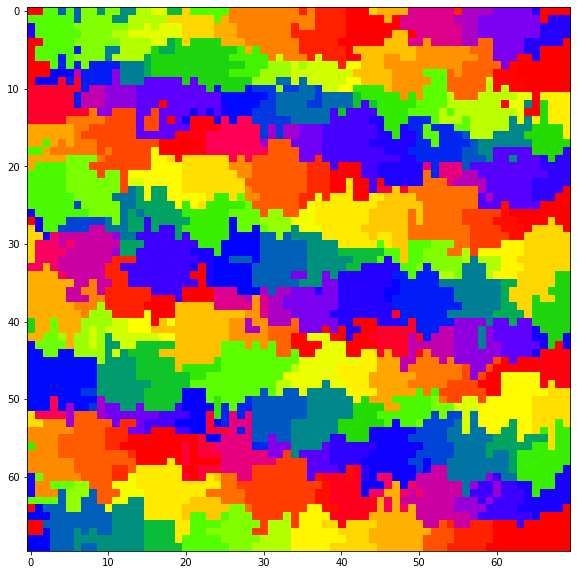

In [746]:
lattice = CellularPottsLattice(
        temperature=t, system=data, size=s, interaction=interaction_matrix, lmbd=lmbd, 
        target_volume=v_t, types_num=types_num, cells_id=ids, cells_size=cells_size
    )

# plt.figure(figsize=(10,10))
# plt.imshow(, interpolation='nearest', cmap=cmap)
# plt.show()

run(lattice, e)

# plt.figure(figsize=(10,10))
# plt.imshow(lattice.system, interpolation='nearest', cmap=cmap)
# plt.show()